In [1]:
import pinocchio as pin
import numpy as np
from pinocchio.visualize import MeshcatVisualizer
import hppfcl as fcl 
from tqdm import trange
import matplotlib.pyplot as plt
import time
import crocoddyl as cdl
import example_robot_data as erd
from tqdm import trange
from multiprocessing import Pool
import imageio
import os
from pathlib import Path
from tqdm import tqdm

In [2]:
from utils.utils import create_pendulum, make_video, RK4Update,aba_with_friction, aba_with_friction2, aba_with_friction3, aba_with_friction5, RK4Update_with_friction

In [3]:
model, geom_model, data, geom_data, _= create_pendulum(1)
q_init = np.zeros(model.nq) + 1.*np.pi
v_init = np.zeros(model.nv)
a_init = np.zeros(model.nv)
x0 = np.concatenate([q_init, v_init])

In [5]:
def smooth_aba_with_friction(model,data,q,v,u,cf,dt,noiseIntensity,nbSamples):
    a = np.zeros_like(v)
    for i in range(nbSamples):
        a_i, _ = aba_with_friction5(model,data,q,v,u+noiseIntensity*np.random.normal(0.,1.,1),cf,dt)
        a += a_i
    a /= nbSamples
    return a 

def compute_cost(model,data,q,v,u,final):
    wef_cur, wef_final = 2.,2.
    wur_cur, wur_final = 2e-3,2e-3
    wxr_cur, wxr_final = 2e-2, 2e-2
    cost_tot = 0.
    if final:
        cost_tot += wef_final*.5*np.sum(np.square(np.array([0.,np.sin(q), np.cos(q)-1])))
        cost_tot += wur_final*.5*np.sum(np.square(u))
        cost_tot += wxr_final*.5*np.sum(np.square(v))
        
    else:
        cost_tot += wef_cur*.5*np.sum(np.square(np.array([0.,np.sin(q), np.cos(q)-1])))
        cost_tot += wur_cur*.5*np.sum(np.square(u))
        cost_tot += wxr_cur*.5*np.sum(np.square(v))
    return cost_tot 

def Q_0(x,u,us,model,data,pert,dt):
    Qvalue = 0.
    q, v = x[:model.nq], x[model.nq:]
    if pert:
        nbSamples= 512
        noiseIntensity = .07
        a= smooth_aba_with_friction(model,data,q,v,u,cf,dt,noiseIntensity,nbSamples)
    else:
        a, _ = aba_with_friction5(model,data,q,v,u,cf,dt)
    v = v + dt*a
    q = pin.integrate(model,q,v*dt)
    pin.forwardKinematics(model, data, q)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data)
    Qvalue += compute_cost(model,data,q,v,u,False)
    for t in range(len(us)-1):
        if pert:
            nbSamples= 512
            noiseIntensity = .07
            a= smooth_aba_with_friction(model,data,q,v,us[t],cf,dt,noiseIntensity,nbSamples)
        else:
            a, _ = aba_with_friction5(model,data,q,v,us[t],cf,dt)
        v = v + dt*a
        q = pin.integrate(model,q,v*dt)
        pin.forwardKinematics(model, data, q)
        pin.updateGeometryPlacements(model, data, geom_model, geom_data)
        Qvalue += compute_cost(model,data,q,v,us[t],False)
    if pert:
        nbSamples= 512
        noiseIntensity = .07
        a= smooth_aba_with_friction(model,data,q,v,us[-1],cf,dt,noiseIntensity,nbSamples)
    else:
        a, _ = aba_with_friction5(model,data,q,v,us[-1],cf,dt)
    v = v + dt*a
    q = pin.integrate(model,q,v*dt)
    pin.forwardKinematics(model, data, q)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data)
    Qvalue += compute_cost(model,data,q,v,us[-1],True)
    return Qvalue

import matplotlib.ticker as tick 
from matplotlib import cm
import matplotlib.pyplot as plt 

def plot_Q_function(x,u,us,cf,dt,model,data,delta_u, pert=False,save=False):
    Qvalues = np.zeros(delta_u.shape[0])
    for i in trange(delta_u.shape[0]):
            delta = np.zeros(u.shape)
            delta[0] = delta_u[i]
            Qvalue = Q_0(x,u+delta,us,model,data,pert,dt)
            Qvalues[i] = Qvalue
    plt.figure()
    plt.plot(delta_u,Qvalues, linewidth = 3.)
    plt.grid(linestyle = "--", linewidth=.4)
    plt.xlabel(r'$\Delta u$', fontsize = 26)
    plt.ylabel(r'$Q_0(x,u+\Delta u)$', fontsize = 26)
    plt.tight_layout()
    if save:
        path_curr = Path.cwd()
        save_path = path_curr/'logs'/'pendulum'
        os.makedirs(save_path,exist_ok=True)
        if pert:
            plt.savefig(save_path/"Q_0_pert.pdf")
        else:
            plt.savefig(save_path/"Q_0.pdf")
    plt.show()
    plt.close()

Ngrid = 100
delta_u = np.linspace(-1.,1.,Ngrid)
T=1000
dt = 5e-3
cf = .1
plot_Q_function(np.array([np.pi,0.]),np.zeros(1),np.zeros((T-1,1)),cf,dt,model,data,delta_u,pert = True,save=True)


  0%|                                                                                                                                                                               | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_9475/3919548852.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cost_tot += wef_cur*.5*np.sum(np.square(np.array([0.,np.sin(q), np.cos(q)-1])))
/tmp/ipykernel_9475/3919548852.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cost_tot += wef_final*.5*np.sum(np.square(np.array([0.,np.sin(q), np.cos(q)-1])))
100%|█████████████████

In [30]:
dt = 0.001
T = 10000
q,v,a = q_init, v_init, a_init
u = 0.*np.ones((T,model.nv))
positions = []
for i in range(T):
    q,v = RK4Update(model,data, q, v, u[i] , dt)
    pin.forwardKinematics(model, data, q)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data)
    positions += [q.copy()]

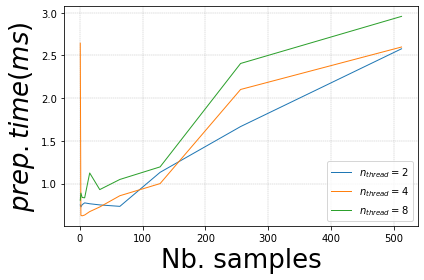

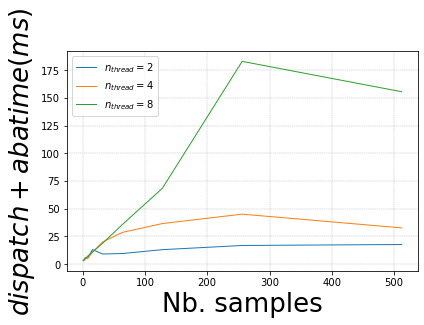

In [9]:
from multiprocessing import Pool, cpu_count
def test_threading(Nb_samples=32, nbThread=2, verbose = False):
    dt = 0.001
    #Nb_samples = 16
    q,v,a = q_init, v_init, a_init
    u = 0.*np.ones((Nb_samples,model.nv))
    t0 = time.time()
    mean_a = 0
    for i in range(Nb_samples):
        a_next, _ = aba_with_friction5(model,data,q,v,u[0],1.*np.ones(model.nv),dt)
        mean_a += a_next/Nb_samples
    t1 = time.time()

    #nbThread = 2
    t2 = time.time()
    pool = Pool(min(nbThread, cpu_count()))
    t3 = time.time()
    models_pin = [model.copy() for i in range(nbThread)]
    data_pin = [data.copy() for i in range(nbThread)]
    args = [(models_pin[i%nbThread], data_pin[i%nbThread], q, v, u[0],1.*np.ones(model.nv),dt) for i in range(Nb_samples)]
    t4 = time.time()
    results_samples = pool.starmap(aba_with_friction5, args)
    t4b = time.time()
    results_samples2 = [results_samples[i][0] for i in range(len(results_samples))]
    mean_a = sum(results_samples2)/Nb_samples
    t5 = time.time()
    if verbose:
        print("total single",(t1-t0)*1e3, "ms")
        print("creating pool",(t3-t2)*1e3, "ms")
        print("preparing data",(t4-t3)*1e3, "ms")
        print("aba",(t5-t4)*1e3, "ms")
        print("total multi",(t5-t2)*1e3, "ms")
    return (t1-t0)*1e3, (t3-t2)*1e3, (t4-t3)*1e3, (t4b-t4)*1e3, (t5-t2)*1e3, (t5-t4b)*1e3

nbSamples = [2**i for i in range(10)]
nbThread = [2,4,8]
single_times= {}
multi_times= {}
create_times= {}
prepare_times= {}
aba_times= {}
gather_times = {}
for i in nbSamples:
    single_times[i] = []
    multi_times[i] = []
    create_times[i] = []
    prepare_times[i] = []
    aba_times[i] = []
    gather_times[i] = []
    for j in nbThread:
        t1,t2,t3,t4,t5,t6 = test_threading(i,j)
        single_times[i] += [t1]
        multi_times[i] += [t5]
        create_times[i] += [t2]
        prepare_times[i] += [t3]
        aba_times[i] += [t4]
        gather_times[i] += [t6]
        

plt.figure()
for i in range(len(nbThread)):
    plt.plot(nbSamples,[multi_times[j][i] for j in nbSamples], linewidth = 1., label =r'$n_{thread}=$'+str(nbThread[i]))
plt.plot(nbSamples, [single_times[j][0] for j in nbSamples], linewidth = 1., label ="single thread")
plt.grid(linestyle = "--", linewidth=.4)
plt.xlabel(r'Nb. samples', fontsize = 26)
plt.ylabel(r'$Comp. time (ms)$', fontsize = 26)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

plt.figure()
for i in range(len(nbThread)):
    plt.plot(nbSamples,[create_times[j][i] for j in nbSamples], linewidth = 1., label =r'$n_{thread}=$'+str(nbThread[i]))
plt.grid(linestyle = "--", linewidth=.4)
plt.xlabel(r'Nb. samples', fontsize = 26)
plt.ylabel(r'$create time (ms)$', fontsize = 26)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

plt.figure()
for i in range(len(nbThread)):
    plt.plot(nbSamples,[prepare_times[j][i] for j in nbSamples], linewidth = 1., label =r'$n_{thread}=$'+str(nbThread[i]))
plt.grid(linestyle = "--", linewidth=.4)
plt.xlabel(r'Nb. samples', fontsize = 26)
plt.ylabel(r'$prep. time (ms)$', fontsize = 26)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

plt.figure()
for i in range(len(nbThread)):
    plt.plot(nbSamples,[aba_times[j][i] for j in nbSamples], linewidth = 1., label =r'$n_{thread}=$'+str(nbThread[i]))
plt.grid(linestyle = "--", linewidth=.4)
plt.xlabel(r'Nb. samples', fontsize = 26)
plt.ylabel(r'$dispatch+aba time (ms)$', fontsize = 26)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

plt.figure()
for i in range(len(nbThread)):
    plt.plot(nbSamples,[gather_times[j][i] for j in nbSamples], linewidth = 1., label =r'$n_{thread}=$'+str(nbThread[i]))
plt.grid(linestyle = "--", linewidth=.4)
plt.xlabel(r'Nb. samples', fontsize = 26)
plt.ylabel(r'$gather time (ms)$', fontsize = 26)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [11]:
dt = 0.001
T = 5000
q,v,a = q_init, v_init, a_init
u = 0.*np.ones((T,model.nv))
positions, velocities = [], []
Ec, Ep, Pdiss, friction_values = np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T) 
for i in range(T):
    #v, tau_f = aba_with_friction4(model,data,q,v,u[i],2.*np.ones(model.nv),dt) # acc formulation with power constraint
    #v, tau_f = aba_with_friction3(model,data,q,v,u[i],2.*np.ones(model.nv),dt) # acc formulation wo power constraint
    #v, tau_f = aba_with_friction2(model,data,q,v,u[i],2.*np.ones(model.nv),dt) #impulse formulation
    #v, tau_f = aba_with_friction(model,data,q,v,u[i],1.*np.ones(model.nv),dt)
    a_next, _ = aba_with_friction5(model,data,q,v,u[i],1.*np.ones(model.nv),dt)
    v = v + dt*a_next
    q = pin.integrate(model,q, v*dt)
    pin.forwardKinematics(model, data, q)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data)
    Ec[i] = 0.5*1*((1*v[0])**2)
    Ep[i] = 1*1*9.81*(1+np.cos(q[0]))
    Pdiss[i] = tau_f[0]*v[0]
    friction_values[i] = tau_f[0]
    positions += [q.copy()]
    velocities += [v.copy()]

NameError: name 'tau_f' is not defined

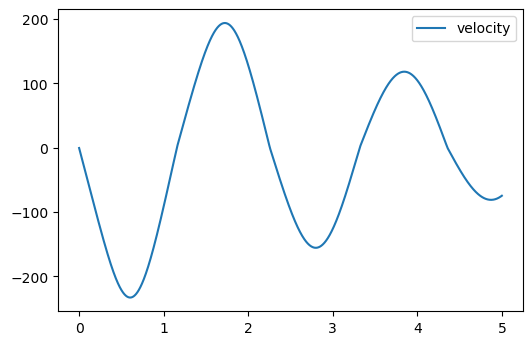

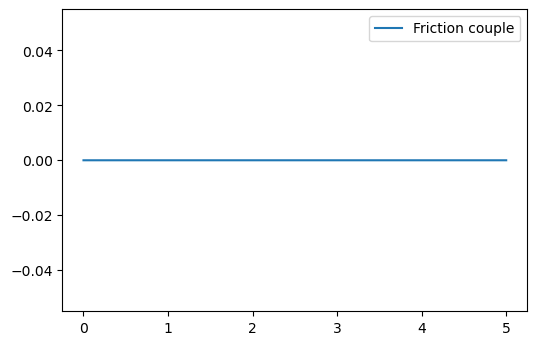

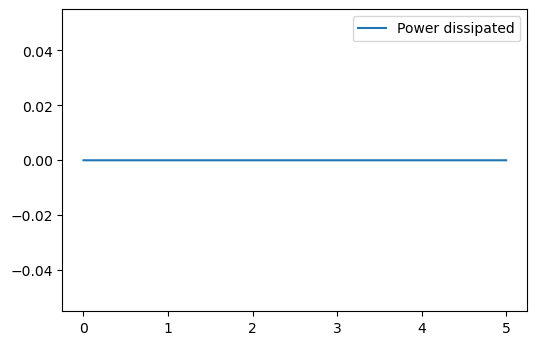

In [16]:
plt.figure(dpi=100)
plt.plot([i*dt for i in range(len(positions))], np.array(positions)*180./np.pi, label = "angle")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot([i*dt for i in range(len(velocities))], np.array(velocities)*180./np.pi, label = "velocity")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot([i*dt for i in range(len(friction_values))], friction_values, label = "Friction couple")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot([i*dt for i in range(len(Ec))], Ec, label = "Ec")
plt.plot([i*dt for i in range(len(Ec))], Ep, label= "Ep")
plt.plot([i*dt for i in range(len(Ec))], Ec+Ep, label = "Etot")
plt.legend()
plt.show()

plt.figure(dpi=100)
plt.plot([i*dt for i in range(len(Pdiss))], Pdiss, label = "Power dissipated")
plt.legend()
plt.show()

In [7]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [27]:
viz.play(np.array(positions).T, dt=0.001)

# Controlling a simple pendulum

In [28]:
class PendulumFwdDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel):
        cdl.DifferentialActionModelAbstract.__init__(self, state, state.nv, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)

    def calc(self, data, x, u=None):
        #print(x)
        if u is None:
            u = self.unone
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = pin.aba(self.state.pinocchio, data.pinocchio, q, v, u)
        #print("u", u)
        #print(data.xout)
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, u)
        data.cost = data.costs.cost
        #print(data.cost)

    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        self.calc(data, x, u)
        # Computing the dynamics derivatives
        pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, u)
        
        Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
        Fui = data.pinocchio.Minv
        
        data.Fx[:] = Fxi
        data.Fu[:] = Fui
        #print("2",data.Fu,data.Fx)
        self.costs.calcDiff(data.costs, x, u)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data
    

In [29]:
# Create the cost functions
target = np.array([0., 0., 1.])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum"), target)
state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
#xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

#w_stateCost = np.array([1.,1e-1])
w_stateCost = np.array([0.,1e-1])
xCost = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(w_stateCost), np.zeros(model.nq + model.nv))

DT = 5e-3

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 2e-0/DT)
runningCostModel.addCost("pendulumPose2", xCost, 2e-1/DT)
#runningCostModel.addCost("stateReg", xRegCost, 1e-7)
runningCostModel.addCost("ctrlReg", uRegCost, 2e-3/DT)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 2e-0)
terminalCostModel.addCost("pendulumPose2", xCost, 2e-1)
#terminalCostModel.addCost("stateReg", xRegCost, 1e-7)
terminalCostModel.addCost("ctrlReg", uRegCost, 2e-3)

# Running and terminal action models
pendulumDAM = PendulumFwdDynamics(state, runningCostModel)
pendulumDAM.createData()
terminalPendulumDAM = PendulumFwdDynamics(state, terminalCostModel)
terminalPendulumDAM.createData()
#runningModel = cdl.IntegratedActionModelEuler(
#    pendulumDAM, DT)
runningModel = cdl.IntegratedActionModelRK4(
    pendulumDAM, DT)
#terminalModel = cdl.IntegratedActionModelEuler(
#    terminalPendulumDAM, 0.)
terminalModel = cdl.IntegratedActionModelRK4(
    terminalPendulumDAM, 0.)

Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated CostModelFrameTranslation: Use ResidualModelFrameTranslation with CostModelResidual
Deprecated CostModelControl: Use ResidualModelControl with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual


In [30]:
T = 1000
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [31]:
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [32]:
init_us = [np.zeros_like(a_init)+0.01]*T
init_xs = problem.rollout(init_us)
ddp.th_stop = 1e-12
ddp.solve(init_xs,init_us,100)

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.00400e+03  4.82583e-06  2.32597e-03  1.00000e-09  1.00000e-09   1.0000     1
   1  4.00398e+03  1.60870e-05  7.75395e-03  1.00000e-09  1.00000e-09   1.0000     1
   2  4.00395e+03  5.37720e-05  2.59187e-02  1.00000e-09  1.00000e-09   1.0000     1
   3  4.00383e+03  1.79797e-04  8.66649e-02  1.00000e-09  1.00000e-09   1.0000     1
   4  4.00342e+03  6.01351e-04  2.89863e-01  1.00000e-09  1.00000e-09   1.0000     1
   5  4.00204e+03  2.01163e-03  9.69656e-01  1.00000e-09  1.00000e-09   1.0000     1
   6  3.99746e+03  6.72824e-03  3.24320e+00  1.00000e-09  1.00000e-09   1.0000     1
   7  3.98213e+03  2.24750e-02  1.08335e+01  1.00000e-09  1.00000e-09   1.0000     1
   8  3.93129e+03  7.46926e-02  3.60018e+01  1.00000e-09  1.00000e-09   1.0000     1
   9  3.76642e+03  2.43680e-01  1.17429e+02  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  3.28126e

True

  24  3.54106e+02  3.80744e-13  1.82896e-10  1.00000e-09  1.00000e-09   1.0000     1


In [33]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [34]:
viz.display(q_init)
time.sleep(2.)
xs = np.stack(ddp.xs)
#s = np.array(init_xs)

viz.play(xs[:,:model.nq].T,DT)

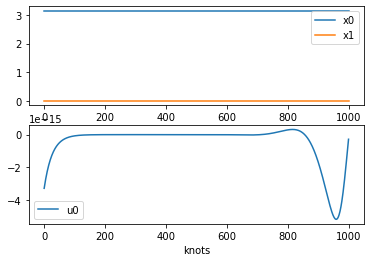

In [320]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

# Controlling a pendulum with smoothed dynamics

Adding noise to the smooth dynamics should help to avoid local optima and saddle points because of the smoothing effect but also to the noise from MC estimators which leads to more stable solutions.

In [9]:
class PendulumSmoothFwdDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, nbSamples, noiseIntensity, multithreading = False):
        cdl.DifferentialActionModelAbstract.__init__(self, state, state.nv, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.nbSamples = nbSamples
        self.noiseIntensity = noiseIntensity
        self.costWeights = 0
        self.multithreading = multithreading

    def calc(self, data, x, u=None, uNoise = None):
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        if u is None:
            u = self.unone
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = 0
        if self.multithreading:
            pool = Pool(self.nbSamples)
            args_u = u+uNoise
            args = [(self.state.pinocchio, data.pinocchio, q, v, U, self.cf) for U in args_u]
            results_samples = pool.starmap(aba_with_friction, args)
            data.xout += sum(results_samples)/self.nbSamples
        else:
            for ui in uNoise:
                data.xout[:] += pin.aba(self.state.pinocchio, data.pinocchio, q, v, u+ ui)/self.nbSamples
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, u)
        data.cost = data.costs.cost
        #print(data.cost)
        


    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        self.calc(data, x, u, uNoise)
        # Computing the dynamics derivatives
        data.Fx[:] = 0
        data.Fu[:] = 0
        for ui in uNoise:
            pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, u+ui)
            Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
            Fui = data.pinocchio.Minv
            for i in range(self.state.nv):
                if np.abs(v)[i]<1e-3:
                    if data.xout[i] != 0:
                        continue
                    else:
                        Fxi[i][:] = 0
                        Fui[i][:] = 0
                else:
                    continue
            data.Fx[:] += Fxi[0]/self.nbSamples
            data.Fu[:] += Fui/self.nbSamples
        #print(data.Fx, data.Fu)
        # Computing the cost derivatives
        self.costs.calcDiff(data.costs, x, u)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data

In [357]:
# Create the cost functions
target = np.array([0., 0., 1.])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum"), target)
state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
#xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

#w_stateCost = np.array([1.,1e-1])
w_stateCost = np.array([0.,1e-1])
xCost = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(w_stateCost), np.zeros(model.nq + model.nv))

DT = 5e-3

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 2e-0/DT)
runningCostModel.addCost("pendulumPose2", xCost, 2e-1/DT)
#runningCostModel.addCost("stateReg", xRegCost, 1e-7)
runningCostModel.addCost("ctrlReg", uRegCost, 2e-3/DT)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 2e-0)
terminalCostModel.addCost("pendulumPose2", xCost, 2e-1)
#terminalCostModel.addCost("stateReg", xRegCost, 1e-7)
terminalCostModel.addCost("ctrlReg", uRegCost, 2e-3)

noiseIntensity = 1e-1
nbSamples = 4
# Running and terminal action models
pendulumDAM = PendulumSmoothFwdDynamics(state, runningCostModel, nbSamples, noiseIntensity)
pendulumDAM.createData()
terminalPendulumDAM = PendulumSmoothFwdDynamics(state, terminalCostModel, nbSamples, noiseIntensity)
terminalPendulumDAM.createData()
#runningModel = cdl.IntegratedActionModelEuler(
#    pendulumDAM, DT)
runningModel = cdl.IntegratedActionModelRK4(
    pendulumDAM, DT)
#terminalModel = cdl.IntegratedActionModelEuler(
#    terminalPendulumDAM, 0.)
terminalModel = cdl.IntegratedActionModelRK4(
    terminalPendulumDAM, 0.)

In [358]:
T = 1000
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [359]:
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [360]:
init_us = [np.zeros_like(a_init)]*T
init_xs = problem.rollout(init_us)
#ddp.th_stop = 1e-12
ddp.solve(init_xs,init_us,100)

False

In [361]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7090/static/


In [365]:
xs = np.stack(ddp.xs)
#s = np.array(init_xs)

viz.play(xs[:,:model.nq].T,DT)
print(list(ddp.us))
print(list(ddp.xs))

[array([62.67410472]), array([61.36840127]), array([60.06490714]), array([58.7592413]), array([57.45599795]), array([56.1548844]), array([54.84974494]), array([53.54757203]), array([52.24876625]), array([50.95057759]), array([49.65215548]), array([48.35539137]), array([47.05929641]), array([45.76620181]), array([44.47617936]), array([43.19172339]), array([41.91099695]), array([40.63723089]), array([39.36690098]), array([38.10142339]), array([36.84690247]), array([35.59412318]), array([34.35020534]), array([33.11217374]), array([31.88447461]), array([30.66519097]), array([29.45655256]), array([28.25377794]), array([27.06861969]), array([25.89404688]), array([24.73365438]), array([23.58256867]), array([22.44851856]), array([21.32633166]), array([20.22113305]), array([19.13289905]), array([18.05826922]), array([17.00006626]), array([15.96065232]), array([14.93641728]), array([13.93241061]), array([12.94956365]), array([11.98463359]), array([11.03918528]), array([10.11253068]), array([9.20

In [363]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

# Controlling simple pendulum with dry frictions 

In [50]:
from utils.utils import aba_with_friction5, aba_with_friction2, RK4Update_with_friction

In [51]:
class FrictionalPendulumFwdDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, cf, dt):
        cdl.DifferentialActionModelAbstract.__init__(self, state, state.nv, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.costWeights = 0
        self.cf = cf
        self.dt = dt
        self.model = state.pinocchio

    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone
        q, v = x[:self.model.nq], x[-self.model.nv:]
        # Computing the dynamics using ABA or manually for armature case
        a_next, _ = aba_with_friction5(self.model, data.pinocchio, q, v, u, self.cf, self.dt)
        #q_next = pin.integrate(self.model,q, v_next*self.dt)
        data.xout[:] = a_next
        #data.xout += pin.aba(self.state.pinocchio, data.pinocchio, q, v, u)
        
        # Computing the cost value and residuals
        pin.forwardKinematics(self.model, data.pinocchio, q, v)
        pin.updateFramePlacements(self.model, data.pinocchio)
        self.costs.calc(data.costs, x, u)
        data.cost = data.costs.cost
        #print(data.cost)

    def calcDiff(self, data, x, u=None):
        q, v = x[:self.model.nq], x[-self.model.nv:]
        if u is None:
            u = self.unone
        self.calc(data, x, u)
        # Computing the dynamics derivatives
        pin.computeABADerivatives(self.model, data.pinocchio, q, v, u)
        Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
        Fui = data.pinocchio.Minv
        #print("1",data.Fu,data.Fx)
        for i in range(self.model.nv):
            if np.abs(v)[i]<1e-3:
                if data.xout[i] == 0.:
                    #Fxi[i][:] = 0
                    Fui[i][:] = 0
        
        data.Fx[:] = Fxi#[0]
        data.Fu[:] = Fui
        #print("2",data.Fu,data.Fx)
        self.costs.calcDiff(data.costs, x, u)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.model.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data
    

In [53]:
# Create the cost functions
DT = 5e-3
target = np.array([0., 0., 1.])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum"), target)
state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
#xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

#w_stateCost = np.array([1.,1e-1])
w_stateCost = np.array([0.,1e-1])
xCost = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(w_stateCost), np.zeros(model.nq + model.nv))


# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 2e-0/DT)
runningCostModel.addCost("pendulumPose2", xCost, 2e-1/DT)
#runningCostModel.addCost("stateReg", xRegCost, 1e-7)
runningCostModel.addCost("ctrlReg", uRegCost, 2e-3/DT)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 2e-0)
terminalCostModel.addCost("pendulumPose2", xCost, 2e-1)
#terminalCostModel.addCost("stateReg", xRegCost, 1e-7)
terminalCostModel.addCost("ctrlReg", uRegCost, 2e-3)

# Running and terminal action models
#actuationModel = cdl.ActuationModelFull(state)
pendulumDAM = FrictionalPendulumFwdDynamics(state, runningCostModel, 0.0,DT)
#pendulumDAM = cdl.DifferentialActionModelNumDiff(pendulumDAM,False)
pendulumDAM.createData()
terminalPendulumDAM = FrictionalPendulumFwdDynamics(state, terminalCostModel, 0.0, DT)
#terminalPendulumDAM = cdl.DifferentialActionModelNumDiff(terminalPendulumDAM,False)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelEuler(pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelEuler(terminalPendulumDAM, 0.)

Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated: Do not use FrameTranslation.
Deprecated CostModelFrameTranslation: Use ResidualModelFrameTranslation with CostModelResidual
Deprecated CostModelControl: Use ResidualModelControl with CostModelResidual
Deprecated CostModelState: Use ResidualModelState with CostModelResidual


In [54]:
# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 1000
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [55]:
# Creating the DDP solver for this OC problem, defining a loggeras no attribute 'p
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [56]:
# Solving it with the DDP algorithm
init_us = [np.zeros_like(a_init)+0.01]*T
init_xs = problem.rollout(init_us)
ddp.solve(init_xs,init_us, 100)

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.00400e+03  4.82637e-06  2.32614e-03  1.00000e-09  1.00000e-09   1.0000     1
   1  4.00398e+03  1.60893e-05  7.75474e-03  1.00000e-09  1.00000e-09   1.0000     1
   2  4.00395e+03  5.37815e-05  2.59222e-02  1.00000e-09  1.00000e-09   1.0000     1
   3  4.00383e+03  1.79836e-04  8.66799e-02  1.00000e-09  1.00000e-09   1.0000     1
   4  4.00341e+03  6.01505e-04  2.89925e-01  1.00000e-09  1.00000e-09   1.0000     1
   5  4.00204e+03  2.01224e-03  9.69907e-01  1.00000e-09  1.00000e-09   1.0000     1
   6  3.99745e+03  6.73059e-03  3.24420e+00  1.00000e-09  1.00000e-09   1.0000     1
   7  3.98213e+03  2.24839e-02  1.08374e+01  1.00000e-09  1.00000e-09   1.0000     1
   8  3.93126e+03  7.47261e-02  3.60165e+01  1.00000e-09  1.00000e-09   1.0000     1
   9  3.76632e+03  2.43798e-01  1.17481e+02  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  3.28095e

True

  21  3.54104e+02  6.22005e-10  2.98777e-07  1.00000e-09  1.00000e-09   1.0000     1


In [47]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [48]:
xs = np.stack(ddp.xs)
viz.play(xs[:,:model.nq].T,DT)

In [49]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

# Controlling simple pendulum with dry frictions by smoothing dynamics

Previous experimentations exhibits difficulties when trying to solve the optimal control problem with DDP in the case of non-smooth dynamics. To solve this issue, we use randomized smoothing in order to smooth the dynamics and solve the problem of the pendulum with dry frictions.

In [43]:
class DifferentialSmoothFrictionDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, nbSamples, noiseIntensity, cf, multithreading = False):
        cdl.DifferentialActionModelAbstract.__init__(self, state, state.nv, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.nbSamples = nbSamples
        self.noiseIntensity = noiseIntensity
        self.costWeights = 0
        self.cf = cf
        self.multithreading = multithreading

    def calc(self, data, x, u=None, uNoise = None):
        if uNoise is None:
            uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        if u is None:
            u = self.unone
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = 0
        if self.multithreading:
            pool = Pool(self.nbSamples)
            args_u = u+uNoise
            args = [(self.state.pinocchio, data.pinocchio, q, v, U, self.cf) for U in args_u]
            results_samples = pool.starmap(aba_with_friction, args)
            data.xout += sum(results_samples)/self.nbSamples
        else:
            for ui in uNoise:
                data.xout += aba_with_friction(self.state.pinocchio, data.pinocchio, q, v, u+ ui, self.cf)/self.nbSamples
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, u)
        data.cost = data.costs.cost
        #print(data.cost)
        


    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        self.calc(data, x, u, uNoise)
        # Computing the dynamics derivatives
        data.Fx[:] = 0
        data.Fu[:] = 0
        for ui in uNoise:
            pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, u+ui)
            Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
            Fui = data.pinocchio.Minv
            for i in range(self.state.nv):
                if np.abs(v)[i]<1e-3:
                    if data.xout[i] != 0:
                        continue
                    else:
                        Fxi[i][:] = 0
                        Fui[i][:] = 0
                else:
                    continue
            data.Fx[:] += Fxi[0]/self.nbSamples
            data.Fu[:] += Fui/self.nbSamples
        #print(data.Fx, data.Fu)
        # Computing the cost derivatives
        self.costs.calcDiff(data.costs, x, u)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data

In [45]:
# Create the cost functions
target = np.array([0., 0., 1.])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum"), target)
state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
#xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

#w_stateCost = np.array([1.,1e-1])
w_stateCost = np.array([0.,1e-1])
xCost = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(w_stateCost), np.zeros(model.nq + model.nv))

DT = 5e-3

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 2e-0/DT)
runningCostModel.addCost("pendulumPose2", xCost, 2e-0/DT)
#runningCostModel.addCost("stateReg", xRegCost, 1e-7)
runningCostModel.addCost("ctrlReg", uRegCost, 2e-3/DT)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 2e-0)
terminalCostModel.addCost("pendulumPose2", xCost, 2e-0)
#terminalCostModel.addCost("stateReg", xRegCost, 1e-7)
terminalCostModel.addCost("ctrlReg", uRegCost, 2e-3)

# Running and terminal action models
noiseIntensity = 1e-0
nbSamples = 2
pendulumDAM = DifferentialSmoothFrictionDynamics(state, runningCostModel,nbSamples, noiseIntensity, 0.01, False)
pendulumDAM.createData()
terminalPendulumDAM = DifferentialSmoothFrictionDynamics(state, terminalCostModel,nbSamples, noiseIntensity, 0.01, False)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelRK4(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelRK4(
    terminalPendulumDAM, 0.)

In [46]:
T = 1000
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [47]:
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [48]:
init_us = [np.zeros_like(a_init)]*T
init_xs = problem.rollout(init_us)
ddp.th_stop_ = 1e-12
ddp.solve(init_xs, init_us, 50)

False

In [49]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7073/static/


In [50]:
xs = np.stack(ddp.xs)
viz.play(xs[:,:model.nv].T, DT)

In [51]:
path_curr = Path().cwd()
positions = xs[:,:model.nq]
fps = 20.
dt_fps = 1./fps
red_coeff = int(dt_fps/DT)
positions_to_record = [np.array(positions)[i*red_coeff] for i in range(int(len(positions)/red_coeff))]
os.makedirs(path_curr/'videos'/'pendulum_with_frictions', exist_ok=True)
make_video(viz, np.array(positions_to_record), path_curr/'videos'/'pendulum_with_frictions'/'RSDDP.mp4', fps)

100%|██████████| 100/100 [00:00<00:00, 172.06it/s]


In [662]:
viz.play(np.array(problem.rollout(ddp.us))[:,:model.nv].T, DT)

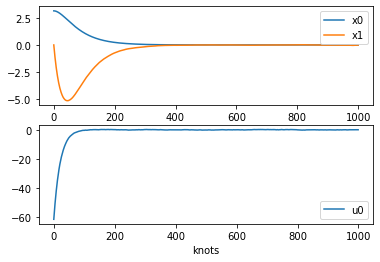

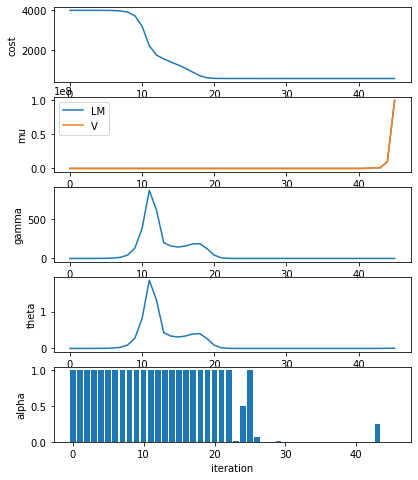

In [661]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

In [667]:
print("Collected reward during trajectory:", -log.costs[-1])

Collected reward during trajectory: -587.1558507378818


# Controlling a cartpole

Now we will consider the task of controlling a cartpole. The goal is to put the mass at a vertical position

In [17]:
def create_cartpole(N):
    model = pin.Model()
    geom_model = pin.GeometryModel()
    
    parent_id = 0
    
    cart_radius = 0.1
    cart_length = 5 * cart_radius
    cart_mass = 2.
    joint_name = "joint_cart"

    geometry_placement = pin.SE3.Identity()
    geometry_placement.rotation = pin.Quaternion(np.array([0.,0.,1.]),np.array([0.,1.,0.])).toRotationMatrix()

    joint_id = model.addJoint(parent_id, pin.JointModelPY(), pin.SE3.Identity(), joint_name)

    body_inertia = pin.Inertia.FromCylinder(cart_mass,cart_radius,cart_length)
    body_placement = geometry_placement
    model.appendBodyToJoint(joint_id,body_inertia,body_placement) # We need to rotate the inertia as it is expressed in the LOCAL frame of the geometry

    shape_cart = fcl.Cylinder(cart_radius, cart_length)

    geom_cart = pin.GeometryObject("shape_cart", joint_id, shape_cart, geometry_placement)
    geom_cart.meshColor = np.array([1.,0.1,0.1,1.])
    geom_model.addGeometryObject(geom_cart)

    parent_id = joint_id
    joint_placement = pin.SE3.Identity()
    body_mass = 1.
    body_radius = 0.1
    for k in range(N):
        joint_name = "joint_" + str(k+1)
        joint_id = model.addJoint(parent_id,pin.JointModelRX(),joint_placement,joint_name)

        body_inertia = pin.Inertia.FromSphere(body_mass,body_radius)
        body_placement = joint_placement.copy()
        body_placement.translation[2] = 1.
        model.appendBodyToJoint(joint_id,body_inertia,body_placement)

        geom1_name = "ball_" + str(k+1)
        shape1 = fcl.Sphere(body_radius)
        geom1_obj = pin.GeometryObject(geom1_name, joint_id, shape1, body_placement)
        geom1_obj.meshColor = np.ones((4))
        geom_model.addGeometryObject(geom1_obj)

        geom2_name = "bar_" + str(k+1)
        shape2 = fcl.Cylinder(body_radius/4.,body_placement.translation[2])
        shape2_placement = body_placement.copy()
        shape2_placement.translation[2] /= 2.

        geom2_obj = pin.GeometryObject(geom2_name, joint_id, shape2, shape2_placement)
        geom2_obj.meshColor = np.array([0.,0.,0.,1.])
        geom_model.addGeometryObject(geom2_obj)

        parent_id = joint_id
        joint_placement = body_placement.copy()
    end_frame=pin.Frame("end_pendulum",model.getFrameId(str(parent_id)), parent_id, body_placement, pin.FrameType(2))
    model.addFrame(end_frame)
    return model, geom_model

In [424]:
class CartpoleFwdDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel):
        cdl.DifferentialActionModelAbstract.__init__(self, state, 1, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.costWeights = 0

    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone
        action = np.zeros(state.nv)
        action[0] = u
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = pin.aba(self.state.pinocchio, data.pinocchio, q, v, action)
        
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, action)
        data.cost = data.costs.cost
        #print(data.cost)

    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        action = np.zeros(state.nv)
        action[0] = u
        self.calc(data, x, u)
        # Computing the dynamics derivatives
        pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, action)
        Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
        Fui = data.pinocchio.Minv
        data.Fx[:] = Fxi
        data.Fu[:] = Fui[:,0]
        #print("2",data.Fu,data.Fx)
        self.costs.calcDiff(data.costs, x, action)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data

In [18]:
model, geom_model = create_cartpole(1)
data = model.createData()
geom_data = geom_model.createData()
q_init = np.zeros(model.nq)
q_init[1] =  1.*np.pi
v_init = np.zeros(model.nv)
a_init = np.zeros(model.nv)
x0 = np.concatenate([q_init, v_init])

In [20]:
print(model.nv)

2


In [597]:
# Create the cost functions
#target = np.array([0., 0., 1.])
#Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum"), target)
#target = np.eye(3)
#Mref = cdl.FrameRotation(model.getFrameId("end_pendulum"), target)
#Mref = crocoddyl.FrameTranslation(model.getFrameId("pendulum_frame"), target)
state = cdl.StateMultibody(model)
#goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
#goalTrackingCost = cdl.CostModelFrameRotation(state, Mref)
xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

w_stateCost = np.array([0.,1.,0.,0.1])
xCost = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(w_stateCost), np.zeros(4))

DT = 5e-3

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
#runningCostModel.addCost("pendulumPose", goalTrackingCost, 1e-7)
runningCostModel.addCost("pendulumPose", xCost, 1e-0/DT)
runningCostModel.addCost("stateReg", xRegCost, 1e-2/DT)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-3/DT)
#terminalCostModel.addCost("pendulumPose", goalTrackingCost, 1e-0)
terminalCostModel.addCost("pendulumPose", xCost, 1e-0)
terminalCostModel.addCost("stateReg", xRegCost, 1e-2)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-3)

# Running and terminal action models
pendulumDAM = CartpoleFwdDynamics(state, runningCostModel)
pendulumDAM.createData()
terminalPendulumDAM = CartpoleFwdDynamics(state, terminalCostModel)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelRK4(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelRK4(
    terminalPendulumDAM, 0.)

In [598]:
# For this optimal control problem, we define 5000 knots (or running action
# models) plus a terminal knot
T = 3000
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [599]:
# Creating the DDP solver for this OC problem, defining a loggeras no attribute 'p
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [600]:
# Solving it with the DDP algorithm
init_us = [np.zeros(1)]*T
init_xs = problem.rollout(init_us)
ddp.solve(init_xs,init_us,20)

False

In [601]:
name = "cartpole"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7131/static/


In [602]:
xs = np.stack(ddp.xs)
#xs = np.array(init_xs)

viz.play(xs[:,:model.nq].T,DT)

In [603]:
print(xs[-1])

[ 7.67095908  0.05176156  2.31989076 -0.16301086]


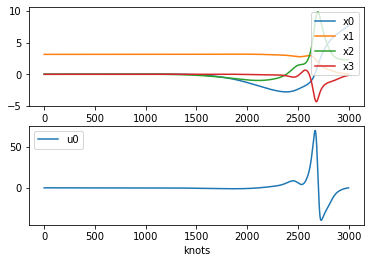

In [604]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

# Controlling a cartpole with dry frictions 

As previously done, we consider the task of controlling a cartpole but we also add dry friction on the basis and pendulum joints.

In [670]:
model, geom_model = create_cartpole(1)
data = model.createData()
geom_data = geom_model.createData()
q_init = np.zeros(model.nq)
q_init[1] =  1.*np.pi
v_init = np.zeros(model.nv)
a_init = np.zeros(model.nv)
x0 = np.concatenate([q_init, v_init])

In [452]:
name = "cartpole"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7102/static/


In [453]:
viz.viewer.jupyter_cell()

In [454]:
dt = 0.001
T = 10000
q,v,a = q_init, v_init, a_init
u = np.zeros((T,model.nv))
cf = np.zeros(model.nv)
cf[0] = 3.*9.81*.08
cf[1] = 0.01
positions = []
for i in range(T):
    q,v = RK4Update_with_friction(model,data, q, v, u[i] , dt, cf)
    pin.forwardKinematics(model, data, q)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data)
    positions += [q.copy()]

In [455]:
viz.play(np.array(positions)[:,:model.nv].T, dt)

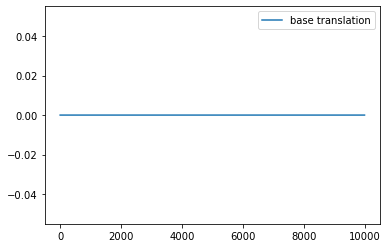

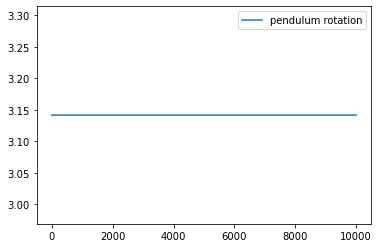

In [456]:
plt.figure()
plt.plot([i for i in range(T)], np.array(positions)[:,0], label = "base translation")
plt.legend()
plt.show()
plt.figure()
plt.plot([i for i in range(T)], np.array(positions)[:,1], label = "pendulum rotation")
plt.legend()
plt.show()

We are going to use a randomly smoothed DDP algorithm to solve the task of raising a cartpole.

In [468]:
class CartpoleFrictionFwdDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, cf):
        cdl.DifferentialActionModelAbstract.__init__(self, state, 1, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.costWeights = 0
        self.cf = cf

    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone
        action = np.zeros(state.nv)
        action[0] = u
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = aba_with_friction(self.state.pinocchio, data.pinocchio, q, v, action, self.cf)
        #data.xout += pin.aba(self.state.pinocchio, data.pinocchio, q, v, u)
        
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, action)
        data.cost = data.costs.cost
        #print(data.cost)

    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        action = np.zeros(state.nv)
        action[0] = u
        self.calc(data, x, u)
        # Computing the dynamics derivatives
        pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, action)
        
        Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
        Fui = data.pinocchio.Minv
        #print("1",data.Fu,data.Fx)
        for i in range(self.state.nv):
            if np.abs(v)[i]<1e-3:
                if data.xout[i] == 0.:
                    Fxi[i][:] = 0
                    Fui[i][:] = 0
        
        data.Fx[:] = Fxi
        data.Fu[:] = Fui[:,0]
        #print("2",data.Fu,data.Fx)
        self.costs.calcDiff(data.costs, x, action)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data

In [614]:
# Create the cost functions
state = cdl.StateMultibody(model)
xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

w_stateCost = np.array([0.,1.,0.,0.1])
xCost = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(w_stateCost), np.zeros(4))

DT = 5e-3

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
#runningCostModel.addCost("pendulumPose", goalTrackingCost, 1e-7)
runningCostModel.addCost("pendulumPose", xCost, 1e-0/DT)
runningCostModel.addCost("stateReg", xRegCost, 1e-2/DT)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-3/DT)
#terminalCostModel.addCost("pendulumPose", goalTrackingCost, 1e-0)
terminalCostModel.addCost("pendulumPose", xCost, 1e-0)
terminalCostModel.addCost("stateReg", xRegCost, 1e-2)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-3)

# Running and terminal action models
cf = np.zeros(model.nv)
cf[0] = 3.*9.81*.00001
cf[1] = 0.00001
pendulumDAM = CartpoleFrictionFwdDynamics(state, runningCostModel, cf)
pendulumDAM.createData()
terminalPendulumDAM = CartpoleFrictionFwdDynamics(state, terminalCostModel,cf)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelEuler(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelEuler(
    terminalPendulumDAM, 0.)

In [615]:
# For this optimal control problem, we define 5000 knots (or running action
# models) plus a terminal knot
T = 3000
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [616]:
# Creating the DDP solver for this OC problem, defining a loggeras no attribute 'p
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [617]:
# Solving it with the DDP algorithm
init_us = [np.zeros(1)]*T
init_xs = problem.rollout(init_us)
ddp.solve(init_xs,init_us,20)

True

In [618]:
name = "cartpole"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7133/static/


In [619]:
xs = np.stack(ddp.xs)
#xs = np.array(init_xs)

viz.play(xs[:,:model.nq].T,DT)

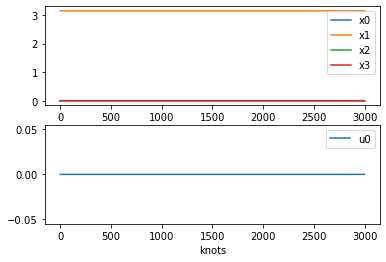

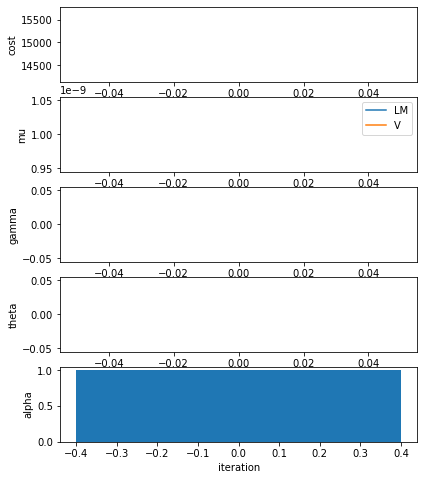

In [620]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

## Solving cartpole with frictions by using randomly smoothed DDP

In [21]:
class CartpoleFrictionSmoothFwdDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, cf, noiseIntesity, nbSamples):
        cdl.DifferentialActionModelAbstract.__init__(self, state, 1, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.costWeights = 0
        self.cf = cf
        self.noiseIntensity = noiseIntensity 
        self.nbSamples = nbSamples

    def calc(self, data, x, u=None, uNoise=None):
        if u is None:
            u = self.unone
        if uNoise is None:
            uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        action = np.zeros(state.nv)
        action[0] = u
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = 0
        for ui in uNoise:
            actioni = np.zeros(state.nv)
            actioni[0] = u + ui
            data.xout[:] += aba_with_friction(self.state.pinocchio, data.pinocchio, q, v, actioni, self.cf)/self.nbSamples
        #data.xout += pin.aba(self.state.pinocchio, data.pinocchio, q, v, u)
        
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, action)
        data.cost = data.costs.cost
        #print(data.cost)

    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        action = np.zeros(state.nv)
        action[0] = u
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        self.calc(data, x, u, uNoise)
        data.Fx[:] = 0
        data.Fu[:] = 0
        for j in range(self.nbSamples):
            actioni = np.zeros(state.nv)
            actioni[0] = u + uNoise[j]
            # Computing the dynamics derivatives
            pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, actioni)

            Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
            Fui = data.pinocchio.Minv
            #print("1",data.Fu,data.Fx)

            for i in range(self.state.nv):
                if np.abs(v)[i]<1e-3:
                    if data.xout[i] == 0.:
                        Fxi[i][:] = 0
                        Fui[i][:] = 0

            data.Fx[:] += Fxi
            data.Fu[:] += Fui[:,0]
        #print("2",data.Fu,data.Fx)
        self.costs.calcDiff(data.costs, x, action)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data

In [22]:
# Create the cost functions
state = cdl.StateMultibody(model)
xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

w_stateCost = np.array([0.,1.,0.,0.1])
xCost = cdl.CostModelState(state, cdl.ActivationModelWeightedQuad(w_stateCost), np.zeros(4))

DT = 5e-3

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
#runningCostModel.addCost("pendulumPose", goalTrackingCost, 1e-7)
runningCostModel.addCost("pendulumPose", xCost, 1e-0/DT)
runningCostModel.addCost("stateReg", xRegCost, 1e-2/DT)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-3/DT)
#terminalCostModel.addCost("pendulumPose", goalTrackingCost, 1e-0)
terminalCostModel.addCost("pendulumPose", xCost, 1e-0)
terminalCostModel.addCost("stateReg", xRegCost, 1e-2)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-3)

# Running and terminal action models
cf = np.zeros(model.nv)
cf[0] = 3.*9.81*.00001
cf[1] = 0.00001
noiseIntensity = 1e-1
nbSamples = 1
pendulumDAM = CartpoleFrictionSmoothFwdDynamics(state, runningCostModel, cf, noiseIntensity, nbSamples)
pendulumDAM.createData()
terminalPendulumDAM = CartpoleFrictionSmoothFwdDynamics(state, terminalCostModel,cf, noiseIntensity, nbSamples)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelRK4(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelRK4(
    terminalPendulumDAM, 0.)

In [16]:
# For this optimal control problem, we define 5000 knots (or running action
# models) plus a terminal knot
T = 3000
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [17]:
# Creating the DDP solver for this OC problem, defining a loggeras no attribute 'p
ddp = cdl.SolverFDDP(problem)
log = cdl.CallbackLogger()

ddp.setCallbacks([log,
                  cdl.CallbackVerbose()])

In [18]:
# Solving it with the DDP algorithm
init_us = [np.zeros(1)]*T
init_xs = problem.rollout(init_us)
ddp.solve(init_xs,init_us,300)

False

In [19]:
name = "cartpole"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7066/static/


In [27]:
xs = np.stack(ddp.xs)
#xs = np.array(init_xs)

viz.play(xs[:,:model.nq].T,DT)

In [25]:
path_curr = Path().cwd()
positions = xs[:,:model.nq]
fps = 20.
dt_fps = 1./fps
red_coeff = int(dt_fps/DT)
positions_to_record = [np.array(positions)[i*red_coeff] for i in range(int(len(positions)/red_coeff))]
os.makedirs(path_curr/'videos'/'cartpole_with_frictions', exist_ok=True)
make_video(viz, np.array(positions_to_record), path_curr/'videos'/'cartpole_with_frictions'/'OC.mp4', fps)

100%|██████████| 300/300 [00:02<00:00, 132.88it/s]


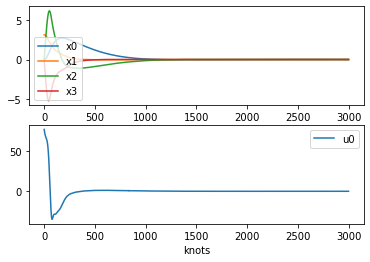

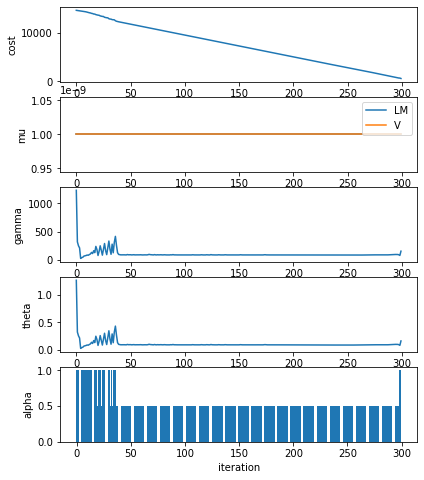

In [21]:
cdl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
cdl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

In [28]:
print(log.costs)

[14547.404958191699, 14515.276548830583, 14498.687188671565, 14442.784424032283, 14426.096188732177, 14407.754081154771, 14363.322438420242, 14329.393268544076, 14273.026691364217, 14233.608166163294, 14168.230434710844, 14121.232867427314, 14050.34245211912, 14010.530361533754, 13924.115089284993, 13888.286253401124, 13789.660884209683, 13778.309194875184, 13667.947331381949, 13614.01177754354, 13560.136346050738, 13533.99900368042, 13406.745307007608, 13352.556983492694, 13300.041562066215, 13286.431243042554, 13121.123606823952, 13065.11868997844, 13029.631784430772, 13011.799380910028, 12829.843042123579, 12762.073366422697, 12746.258995402175, 12640.880888226393, 12630.777570792363, 12602.441903273077, 12415.87130579224, 12311.40004387016, 12252.047905434092, 12202.92625275369, 12158.164500155883, 12113.379729835142, 12069.315726688448, 12025.274136137743, 11980.856440645972, 11936.25675957115, 11891.976976919388, 11848.352094139265, 11803.422094607164, 11759.072254513534, 11714.5